In [1]:
from __future__ import print_function, division
%matplotlib inline

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

Load data

In [2]:
import numpy as np

def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1
            
#read in the fasta files and one-hot encode
fasta_seqs = [x.rstrip() for (i,x) in enumerate(open("positives_test.fa"))
              if i%2==1]
#filter out any sequences that contain 'N's
onehot_data = [np.array(one_hot_encode_along_channel_axis(x))
                         for x in fasta_seqs if ('N' not in x)]
print("Num onehot sequences:",len(onehot_data))

#read in the importance scores and hypothetical importance scores
#filter out any sequences that contain 'N's
hyp_impscores = [w[0] for w in zip([
    np.array( [[float(z) for z in y.split(",")] for y in x.rstrip().split("\t")[2].split(";")])
    for x in open("gkmexplain_positives_hypimpscores.txt")
],fasta_seqs) if 'N' not in w[1]]

impscores = [w[0] for w in zip([
    np.array( [[float(z) for z in y.split(",")] for y in x.rstrip().split("\t")[2].split(";")])
    for x in open("gkmexplain_positives_impscores.txt")
],fasta_seqs) if 'N' not in w[1]]

#Perform a sanity check to make sure that the importance score are the same as the
# hypothetical scores multiplied elementwise with the one-hot encoding; for this
# reason, it is not technically necessary to compute the importance scores if the
# hypothetical scores are also computed
assert (np.max([np.max(np.abs(z*y - x)) for x,y,z in zip(impscores,onehot_data,hyp_impscores)]))==0

#Read in scores on the dinucleotide-shuffled sequences, taking
# the sum across ACGT at each position, to get an empirical null distribution
# of per-position importance scores
nulldist_perposimp = [
    np.array( [sum([float(z) for z in y.split(",")]) for
                y in x.rstrip().split("\t")[2].split(";")])
    for x in open("gkmexplain_dnshuff_impscores.txt")]

Num onehot sequences: 960


In [3]:
!head seqlets.fa

>ex3:2-43
AAGGTTTGTCTTGTTATGCAGATAAGATCTCTCTGGTGATA
>ex3:127-168
CACAAAAGGGGAGATTTATATTCTATTGTTAGGCATTTAGG
>ex5:58-99
GCGCCCCACCTCCAGCTGTTCTCCTCAGGGATGCCTCATTC
>ex11:62-103
TTTTCTGGGCAGCAGGCAAGAACCCATCAGGTTGCTACACA
>ex15:52-93
CTGTGCTGGGGCCCTCATCTGCATCACAAAGTGGCCGTCTG


In [4]:
#loading the coords
import modisco.core
reload(modisco.core)

contrib_scores_track = modisco.core.DataTrack(name="contrib_scores",
                                 fwd_tracks=impscores,
                                 rev_tracks=[x[::-1, ::-1] for x in impscores])
hypcontrib_scores_track = modisco.core.DataTrack(name="hypcontrib_scores",
                                    fwd_tracks=hyp_impscores,
                                    rev_tracks=[x[::-1, ::-1] for x in hyp_impscores])
onehot_track = modisco.core.DataTrack(name="onehot",
                         fwd_tracks=onehot_data,
                         rev_tracks=[x[::-1, ::-1] for x in onehot_data])
track_set = modisco.core.DataTrackSet(data_tracks=[
                contrib_scores_track, hypcontrib_scores_track, onehot_track])

coords = []
for i,line in enumerate(open("seqlets.fa")):
    if (i%2==0):
        beforecolon, aftercolon = line.rstrip().split(":")
        example_idx = int(beforecolon[3:])
        start, end = aftercolon.split("-")
        start, end = int(start), int(end)
        coords.append(modisco.core.Coordinate(
                        example_idx=example_idx, start=start+10,
                        end=end-10, is_revcomp=False))
    
seqlets = track_set.create_seqlets(coords=coords, flanks=10)
    

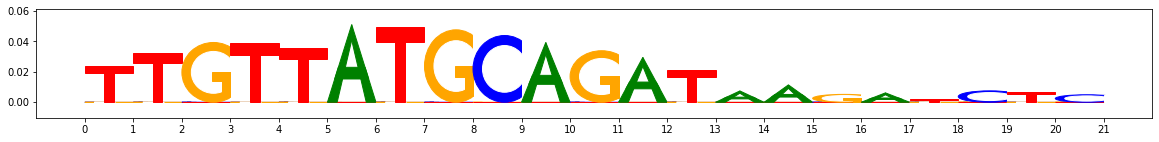

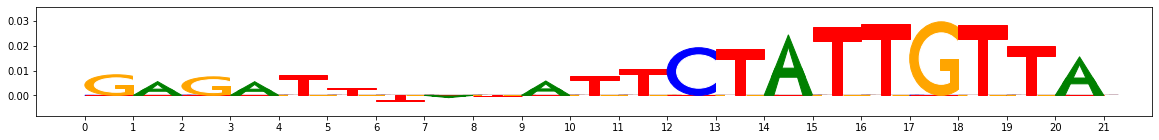

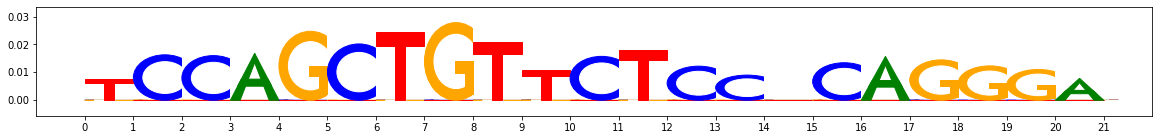

In [5]:
from modisco.visualization import viz_sequence

for seqlet in seqlets[:3]:
    viz_sequence.plot_weights(seqlet["contrib_scores"].corefwd)

In [28]:
import modisco.affinitymat
reload(modisco.affinitymat)
import modisco.util
reload(modisco.util)
import gc
gc.collect()

affmat_computer = modisco.affinitymat.SequenceAffmatComputer_Impute(
                    metric=modisco.util.l1norm_contin_jaccard_sim,
                    n_jobs=4, min_overlap_frac=0.6)

affmat, offsets, isfwdmat = affmat_computer(seqlets[:], onehot_trackname="onehot",
                                            hyp_trackname="hypcontrib_scores")

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  44 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done 344 tasks      | elapsed:    8.7s
[Parallel(n_jobs=4)]: Done 844 tasks      | elapsed:   20.0s
[Parallel(n_jobs=4)]: Done 936 out of 936 | elapsed:   22.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    8.9s
[Parallel(n_jobs=4)]: Done 876 tasks      | elapsed:   21.0s
[Parallel(n_jobs=4)]: Done 936 out of 936 | elapsed:   22.4s finished


Exemplar 0 seqlet 223


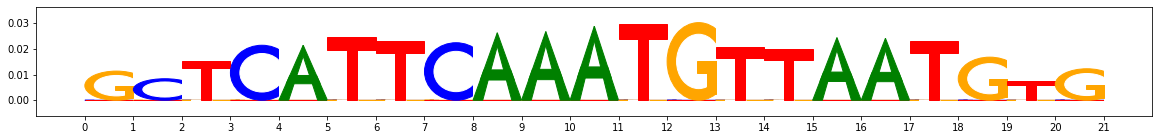

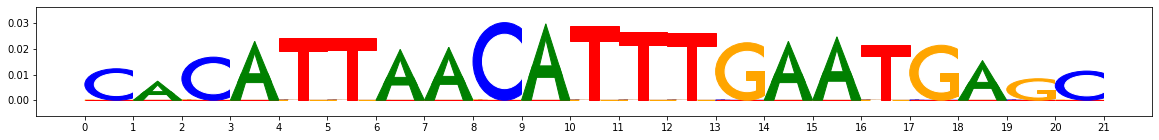

Cluster size: 80


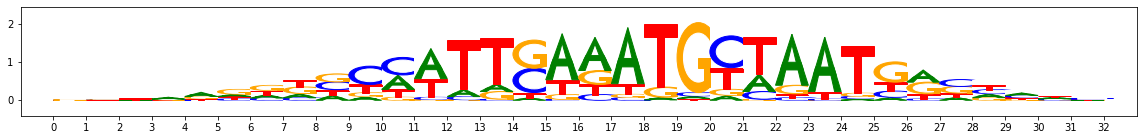

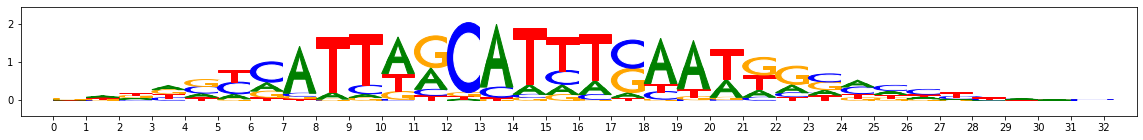

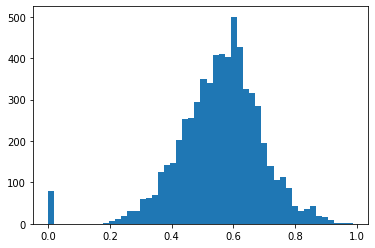

Exemplar 1 seqlet 754


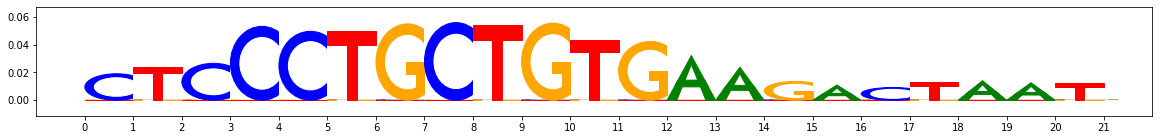

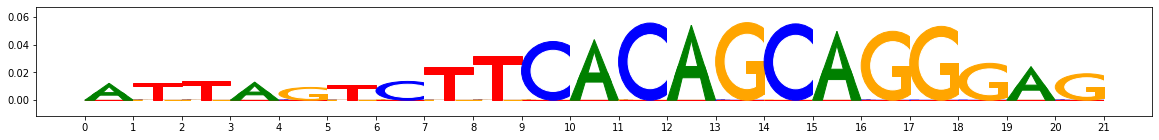

Cluster size: 120


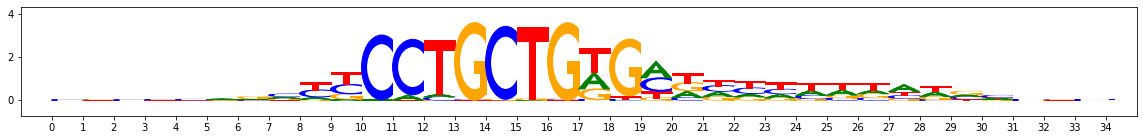

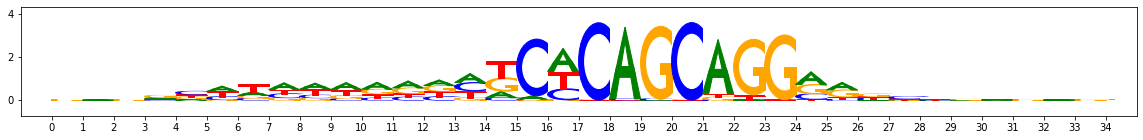

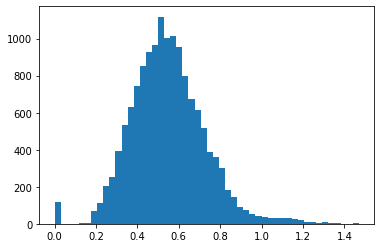

Exemplar 2 seqlet 145


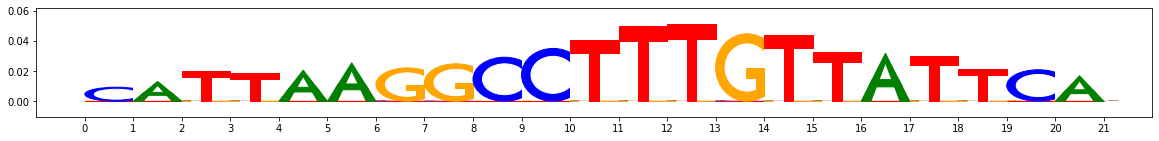

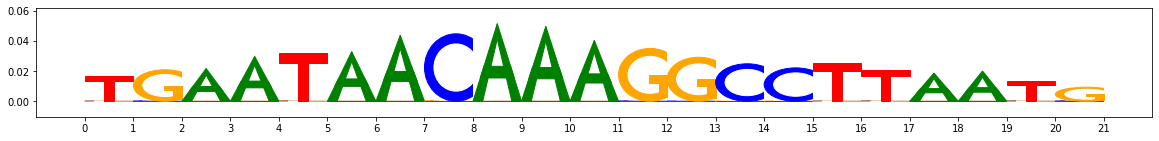

Cluster size: 139


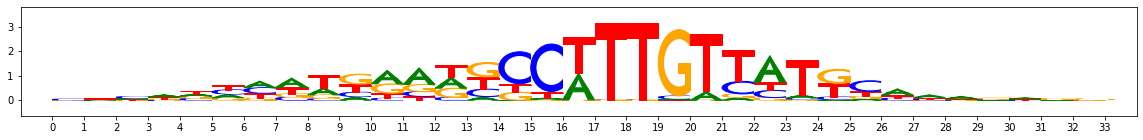

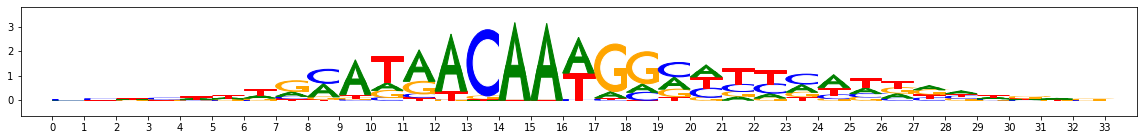

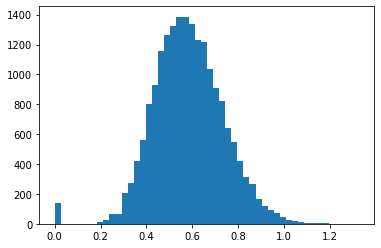

Exemplar 3 seqlet 838


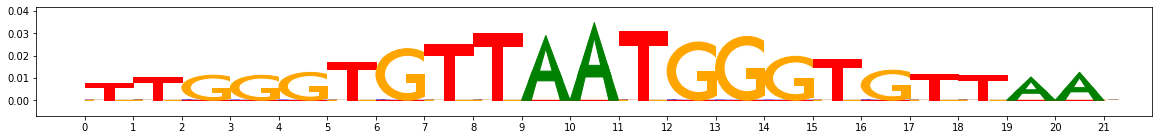

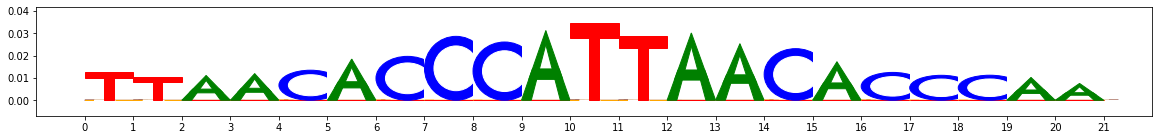

Cluster size: 82


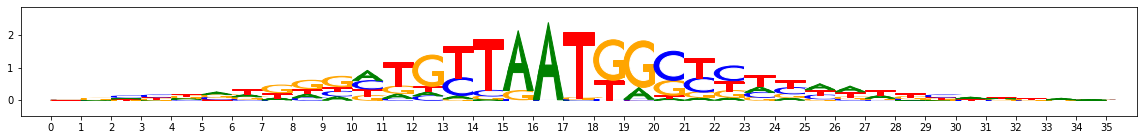

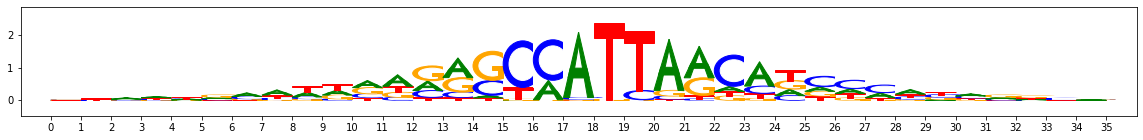

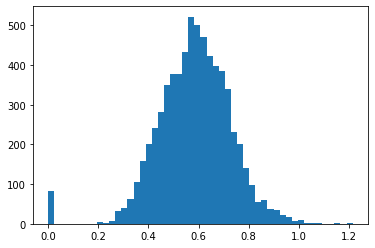

Exemplar 4 seqlet 557


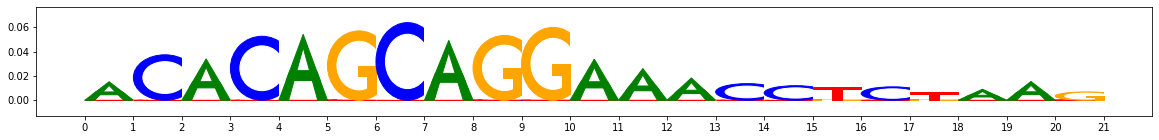

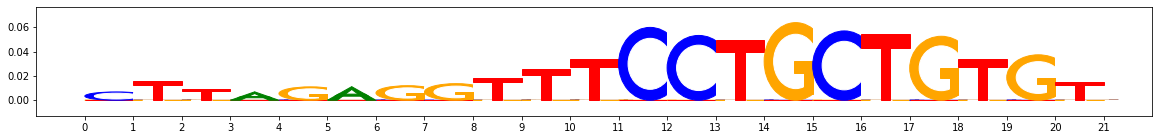

Cluster size: 106


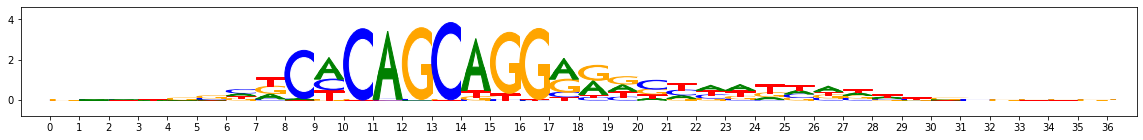

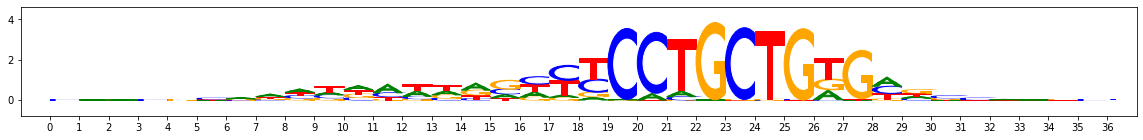

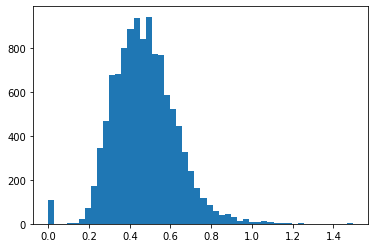

Exemplar 5 seqlet 804


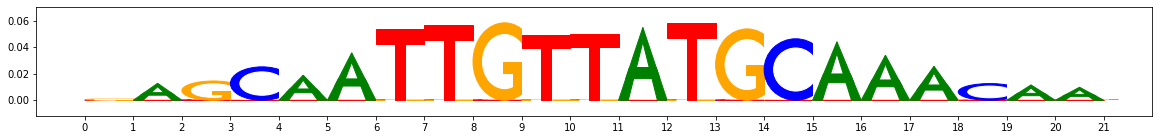

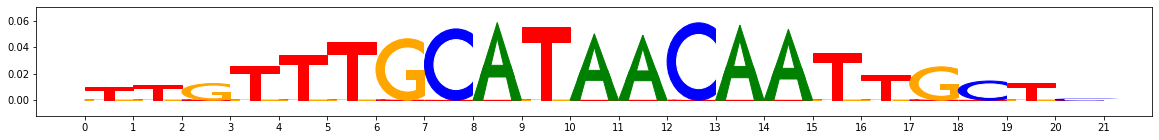

Cluster size: 90


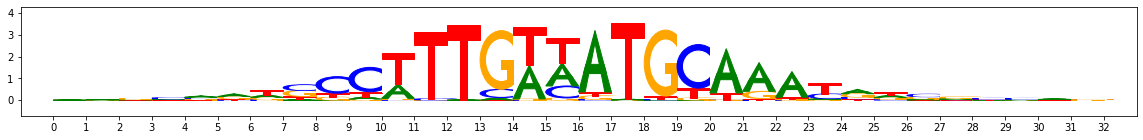

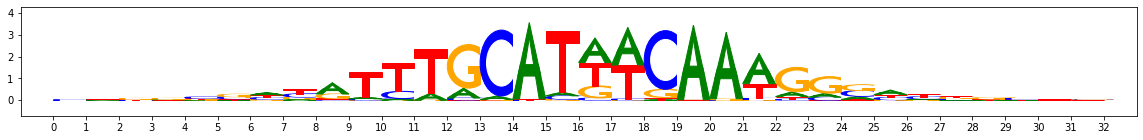

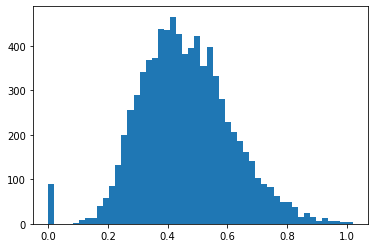

Exemplar 6 seqlet 484


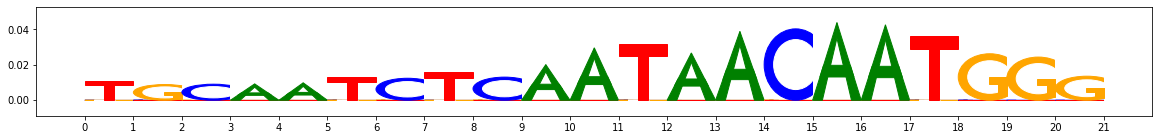

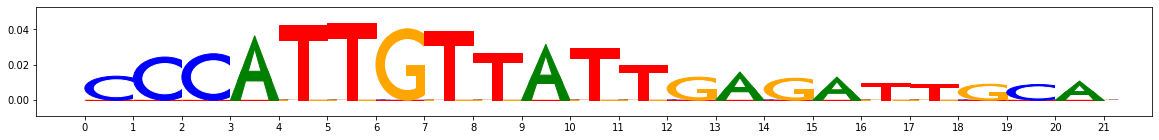

Cluster size: 95


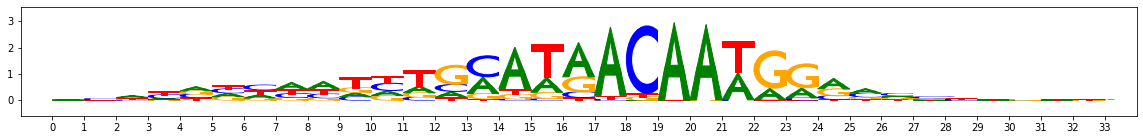

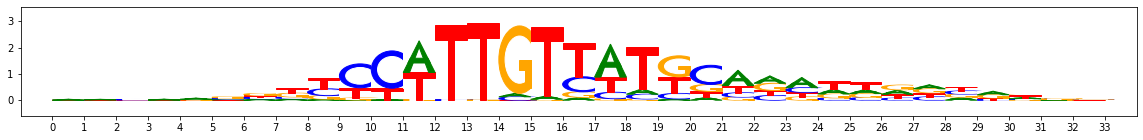

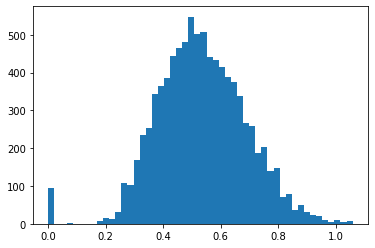

Exemplar 7 seqlet 306


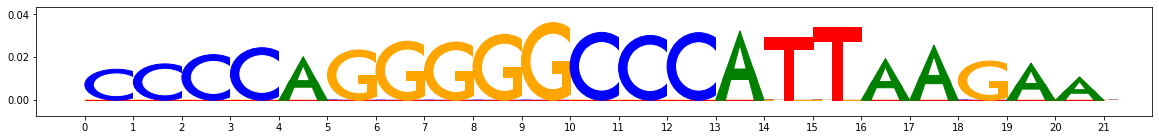

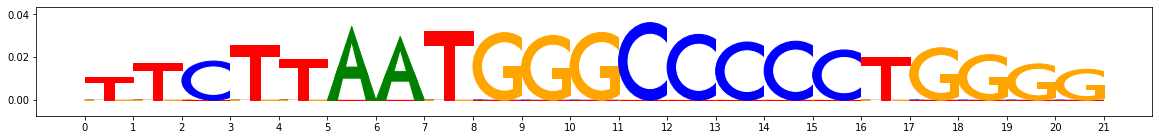

Cluster size: 73


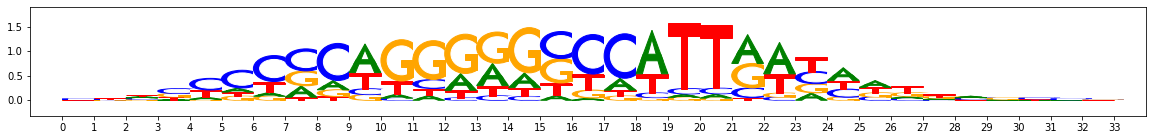

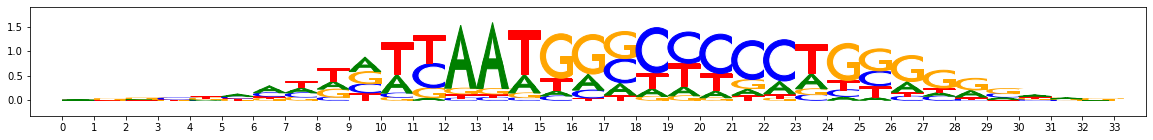

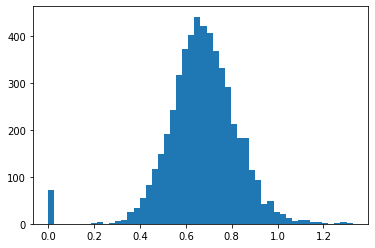

Exemplar 8 seqlet 379


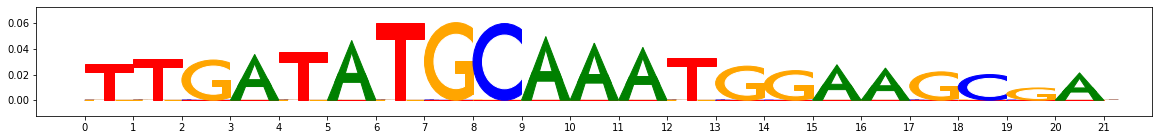

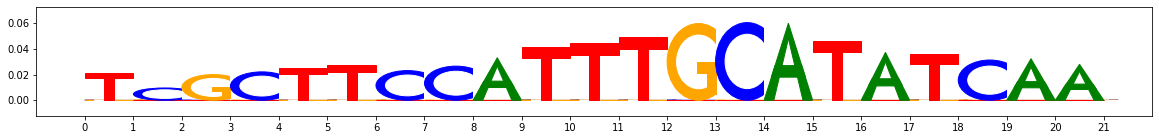

Cluster size: 68


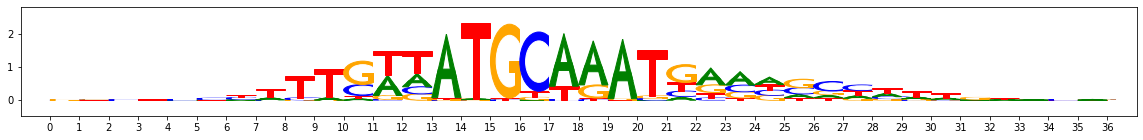

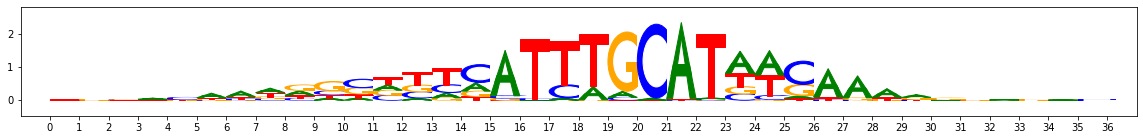

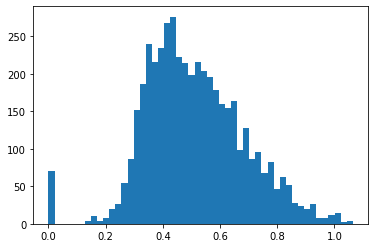

Exemplar 9 seqlet 554


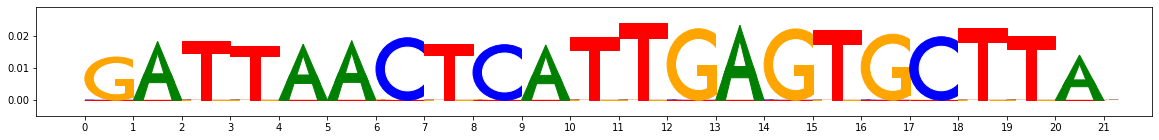

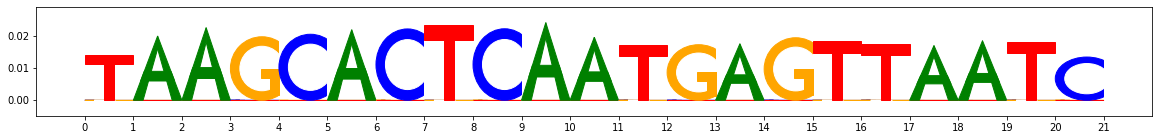

Cluster size: 83


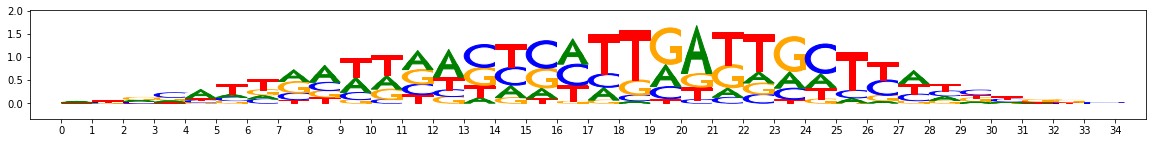

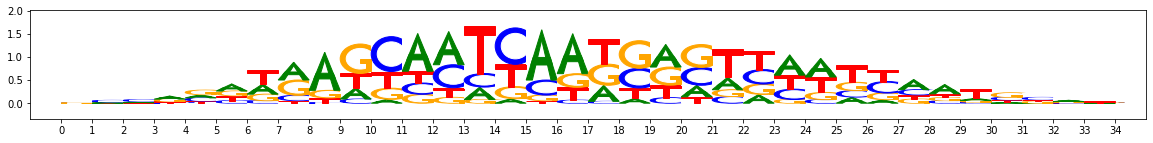

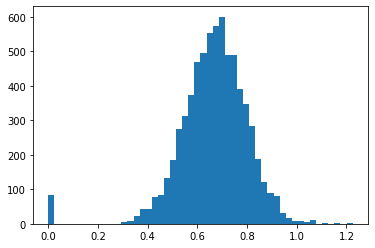

In [42]:
import modisco.core
reload(modisco.core)
import numpy as np
import modisco.util
reload(modisco.util)
from matplotlib import pyplot as plt

distmat = np.log(1.0/np.maximum(affmat,0))
exemplars = modisco.util.facility_locator(distmat)

num_exemplars = 10
exemplar_clusters = np.argmin(distmat[:,exemplars[:num_exemplars]], axis=1)

for exemplar_idx,exemplar in enumerate(exemplars[:num_exemplars]):
    print("Exemplar",exemplar_idx,"seqlet",exemplar)
    viz_sequence.plot_weights(seqlets[exemplar]["contrib_scores"].corefwd)
    viz_sequence.plot_weights(seqlets[exemplar].get_revcomp()["contrib_scores"].corefwd)
    in_cluster_mask = exemplar_clusters==exemplar_idx
    print("Cluster size:",sum(in_cluster_mask))
    #can get the seqlets + their alignment to the exemplar
    distsortinfo = np.argsort(distmat[in_cluster_mask, exemplar])
    isfwdinfo = isfwdmat[in_cluster_mask,exemplar][distsortinfo]
    offsetsinfo = offsets[in_cluster_mask,exemplar][distsortinfo]
    seqlets_in_cluster_allfwd_unsorted = [seqlet for seqlet,incluster in zip(seqlets, in_cluster_mask) if incluster]
    seqlets_in_cluster_allfwd = [seqlets_in_cluster_allfwd_unsorted[i] for i in distsortinfo]
    oriented_seqlets_in_cluster = [(seqlet if isfwd==True else seqlet.get_revcomp())
                                   for (seqlet, isfwd) in zip(seqlets_in_cluster_allfwd, isfwdinfo)]
    #for aseqlet,anoffset,isfwd in list(zip(oriented_seqlets_in_cluster, offsetsinfo, isfwdinfo))[:3]:
    #    print("offset:",anoffset,"isfwd:",isfwd)
    #    viz_sequence.plot_weights(aseqlet["contrib_scores"].corefwd)
    
    aggregated_seqlet = modisco.core.AggregatedSeqlet(seqlets=oriented_seqlets_in_cluster[:100],
                                                      offsets=offsetsinfo[:100])
    viz_sequence.plot_weights(aggregated_seqlet["contrib_scores"].fwd)
    viz_sequence.plot_weights(aggregated_seqlet["contrib_scores"].rev)
    #plot the distribution of pairwise dissimilarities within the cluster
    plt.hist(distmat[in_cluster_mask][:,in_cluster_mask].ravel(), bins=50)
    plt.show()
    

0 1.0 0 True
corefwd 0


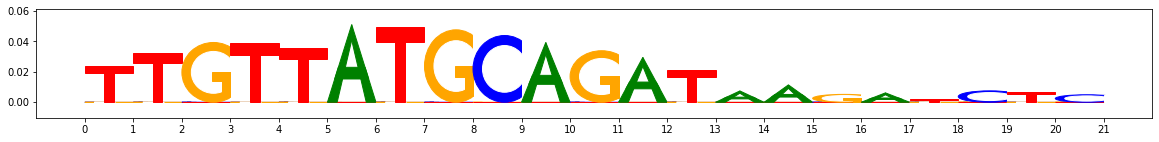

547 0.8441747375705171 2 False
corerev 547


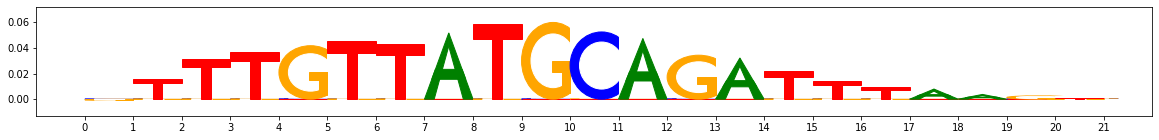

907 0.8334903720889061 7 True
corefwd 907


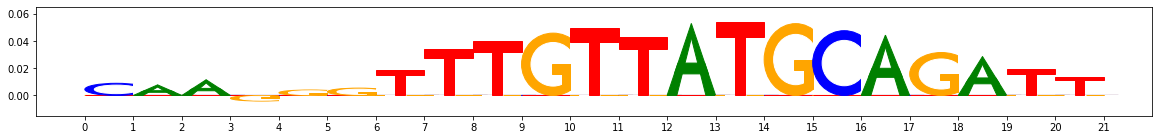

475 0.8186446704247554 6 False
corerev 475


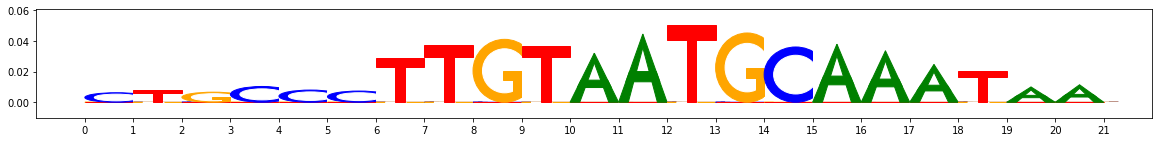

207 0.7950378773184481 4 False
corerev 207


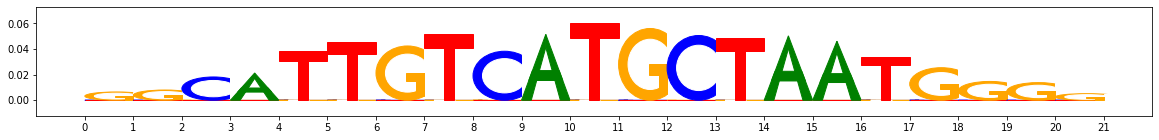

4 0.7881062737737318 2 False
corerev 4


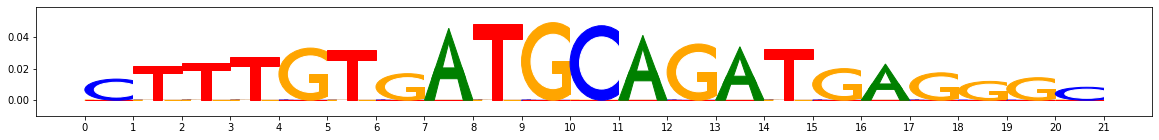

140 0.7758293175682531 4 False
corerev 140


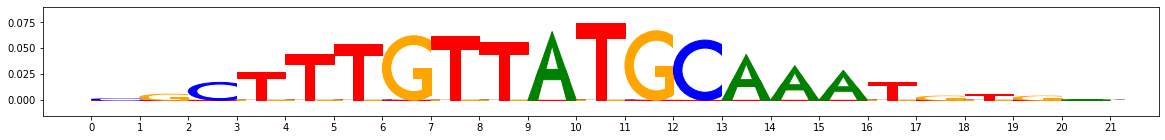

687 0.771442663832151 2 False
corerev 687


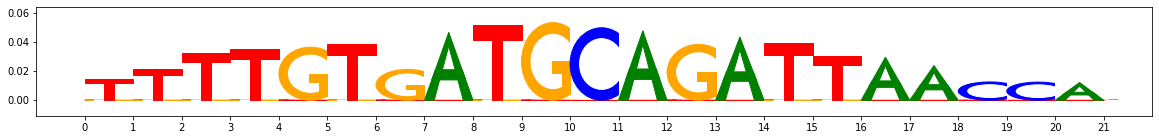

854 0.7664492014184281 0 False
corerev 854


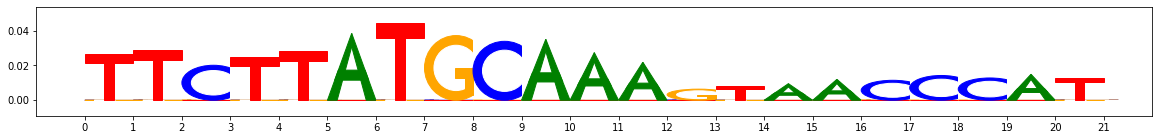

643 0.7650440290506103 1 True
corefwd 643


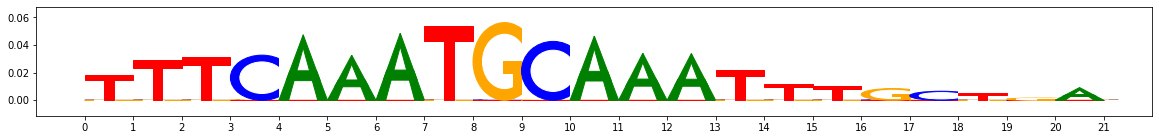

In [74]:
from modisco.visualization import viz_sequence

arow = affmat[0,:]
offsetsinrow = offsets[0,:]
isfwdrow = isfwdmat[0,:]
seqletssubset = seqlets[:]
sortedindices = np.argsort(arow)[::-1]
for idx in sortedindices[:10]:
    print(idx,arow[idx], offsetsinrow[idx], isfwdrow[idx])
    if (isfwdrow[idx]):
        print("corefwd",idx)
        viz_sequence.plot_weights(seqletssubset[idx]["contrib_scores"].corefwd)
    else:
        print("corerev",idx)
        viz_sequence.plot_weights(seqletssubset[idx]["contrib_scores"].corerev)

In [43]:
#do a tsne embedding
import sklearn.manifold

embedding_tsnep10 = sklearn.manifold.TSNE(perplexity=10, metric='precomputed').fit_transform(distmat)
embedding_tsnep30 = sklearn.manifold.TSNE(perplexity=30, metric='precomputed').fit_transform(distmat)

In [51]:
import umap

embedding_umap10 = umap.UMAP(n_neighbors=10, min_dist=0, metric='precomputed').fit_transform(distmat)
embedding_umap30 = umap.UMAP(n_neighbors=30, min_dist=0, metric='precomputed').fit_transform(distmat)

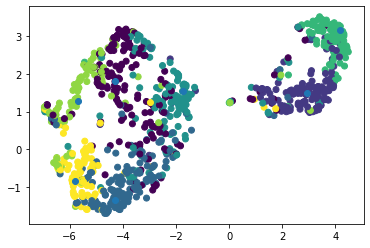

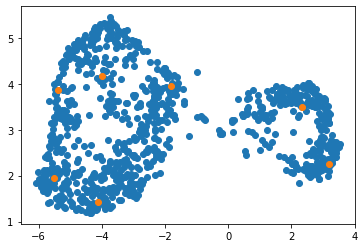

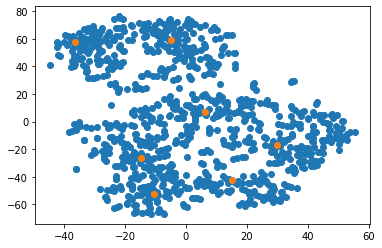

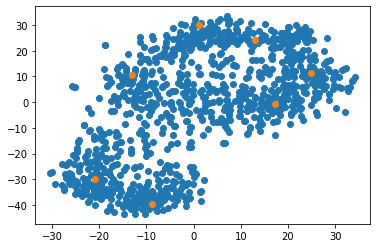

In [70]:
from matplotlib import pyplot as plt

num_exemplars=7
exemplar_clusters = np.argmin(distmat[exemplars[:num_exemplars]], axis=0)

plt.scatter(embedding_umap10[:,0], embedding_umap10[:,1], c=exemplar_clusters)
plt.scatter(embedding_umap10[exemplars[:num_exemplars],0],
            embedding_umap10[exemplars[:num_exemplars],1])
plt.show()
plt.scatter(embedding_umap30[:,0],embedding_umap30[:,1])
plt.scatter(embedding_umap30[exemplars[:num_exemplars],0],
            embedding_umap30[exemplars[:num_exemplars],1])
plt.show()
plt.scatter(embedding_tsnep10[:,0], embedding_tsnep10[:,1])
plt.scatter(embedding_tsnep10[exemplars[:num_exemplars],0],
            embedding_tsnep10[exemplars[:num_exemplars],1])
plt.show()
plt.scatter(embedding_tsnep30[:,0], embedding_tsnep30[:,1])
plt.scatter(embedding_tsnep30[exemplars[:num_exemplars],0],
            embedding_tsnep30[exemplars[:num_exemplars],1])
plt.show()

In [ ]:

#From https://github.com/theislab/scanpy/blob/8d1adb69310fc4b3128242f205f1f6ba561f6d23/scanpy/_utils.py#L159
def get_igraph_from_adjacency(adjacency, directed=None):
    """Get igraph graph from adjacency matrix."""
    import igraph as ig
    sources, targets = adjacency.nonzero()
    weights = adjacency[sources, targets]
    if isinstance(weights, np.matrix):
        weights = weights.A1
    g = ig.Graph(directed=directed)
    g.add_vertices(adjacency.shape[0])  # this adds adjacency.shap[0] vertices
    g.add_edges(list(zip(sources, targets)))
    try:
        g.es['weight'] = weights
    except:
        pass
    if g.vcount() != adjacency.shape[0]:
        logg.warning(
            f'The constructed graph has only {g.vcount()} nodes. '
            'Your adjacency matrix contained redundant nodes.'
        )
    return g

g = get_igraph_from_adjacency(

In [99]:
def compute_sim_on_pair(seqldat1, seqldat2, min_overlap_frac, pair_sim_metric): 
                                                                                
    if (seqldat1.corelen <= seqldat2.corelen):                                  
        shortr_seqldat = seqldat1                                               
        longer_seqldat = seqldat2                                               
    else:                                                                       
        shortr_seqldat = seqldat2                                               
        longer_seqldat = seqldat1                                               
    assert (shortr_seqldat.corelen <= longer_seqldat.corelen)                   
                                                                                
    shortrcorelen = shortr_seqldat.corelen                                      
    longercorelen = longer_seqldat.corelen                                      
    shortrflanklen = shortr_seqldat.flanklen                                    
    longerflanklen = longer_seqldat.flanklen                                    
    shortronehot, shortrhyp = shortr_seqldat.onehot, shortr_seqldat.hyp         
    longeronehot, longerhyp = longer_seqldat.onehot, longer_seqldat.hyp         
                                                                                
    shortractual = shortronehot*shortrhyp                                       
    longeractual = longeronehot*longerhyp                                       
                                                                                
    shortrcorelen = len(shortronehot)-2*shortrflanklen                          
    longercorelen = len(longeronehot)-2*longerflanklen                          
    min_overlap = int(shortrcorelen*min_overlap_frac)                           
                                                                                
    #iterate over all possible offsets of                                       
    # shortr's core relative to longerdata                                      
    leftoffset = -(shortrcorelen-min_overlap)                                   
    rightoffset = longercorelen-min_overlap                                     
                                                                                
    possible_offsets = list(range(leftoffset, rightoffset+1))                   
    sim_results = []                                                            
    for offset in possible_offsets:                                             
        shortr_leftflank = max(offset,0)                                        
        shortr_rightflank = max(longercorelen-(offset+shortrcorelen),0)         
                                                                                
        shortr_slicestart = shortrflanklen-shortr_leftflank                     
        shortr_sliceend = shortrflanklen+shortrcorelen+shortr_rightflank        
                                                                                
        longer_leftflank = max(-offset,0)                                       
        longer_rightflank = max((offset+shortrcorelen)-longercorelen,0)         
        longer_slicestart = longerflanklen-longer_leftflank                     
        longer_sliceend = longerflanklen+longercorelen+longer_rightflank        
                                                                                
        shortractual_slice = shortractual[shortr_slicestart:shortr_sliceend]    
        shortronehot_slice = shortronehot[shortr_slicestart:shortr_sliceend]    
        shortrhyp_slice = shortrhyp[shortr_slicestart:shortr_sliceend]
        longeractual_slice = longeractual[longer_slicestart:longer_sliceend]    
        longeronehot_slice = longeronehot[longer_slicestart:longer_sliceend]    
        longerhyp_slice = longerhyp[longer_slicestart:longer_sliceend]          
                                                                                
        shortr_imputed = shortrhyp_slice*longeronehot_slice                     
        longer_imputed = longerhyp_slice*shortronehot_slice                     
        
        print(offset)
        viz_sequence.plot_weights(shortractual_slice)
        viz_sequence.plot_weights(longer_imputed)
        viz_sequence.plot_weights(longeractual_slice)
        viz_sequence.plot_weights(shortr_imputed)
        
        sim_results.append(                                                     
             0.5*pair_sim_metric(shortractual_slice, longer_imputed)            
           + 0.5*pair_sim_metric(shortr_imputed, longeractual_slice))           
                                                                                
    return max(sim_results)

In [107]:
onehot_trackname="onehot"
hyp_trackname="hypcontrib_scores"
max_seqlet_len = max(len(x) for x in seqlets)
min_overlap_frac=0.67
flank_sizes = [max_seqlet_len-int(len(seqlet)*min_overlap_frac)    
               for seqlet in seqlets]

allfwd_onehot_seqletdata = (np.array(                                   
                            [seqlet[onehot_trackname].get_core_with_flank(      
                             left=flank, right=flank, is_revcomp=False)         
                             for seqlet,flank in zip(seqlets,flank_sizes)])>0)  
allfwd_hyp_seqletdata = np.array(                                       
                            [seqlet[hyp_trackname].get_core_with_flank(         
                             left=flank, right=flank, is_revcomp=False)         
                             for seqlet,flank in zip(seqlets,flank_sizes)])
allrev_onehot_seqletdata = allfwd_onehot_seqletdata[:,::-1,::-1]
allrev_hyp_seqletdata = allfwd_hyp_seqletdata[:,::-1,::-1]

i=44
j=0
seqldat1 = modisco.affinitymat.SeqlDatForImput(corelen=len(seqlets[i]),                
                            onehot=allfwd_onehot_seqletdata[i],     
                            hyp=allfwd_hyp_seqletdata[i])          
seqldat2 = modisco.affinitymat.SeqlDatForImput(                            
                corelen=len(seqlets[j]),                
                onehot=allrev_onehot_seqletdata[j],     
                hyp=allrev_hyp_seqletdata[j])

-7


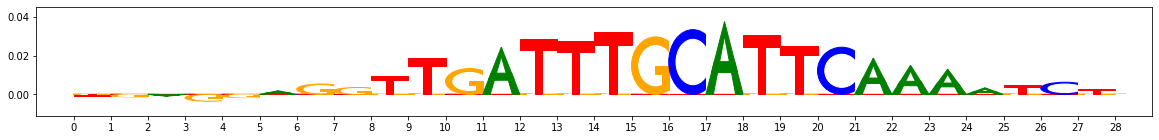

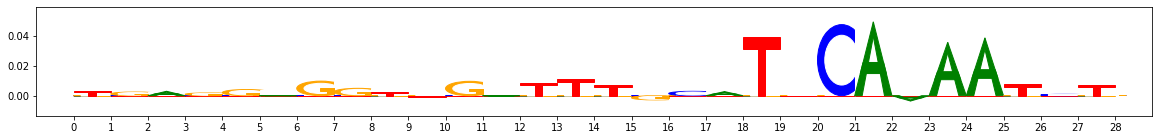

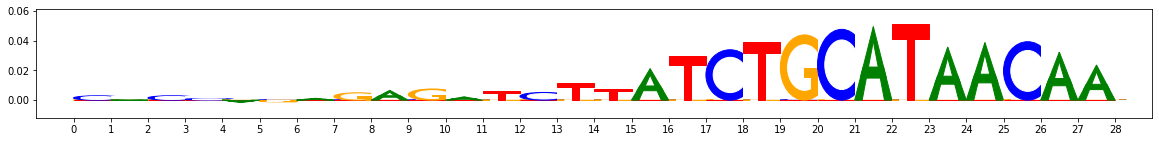

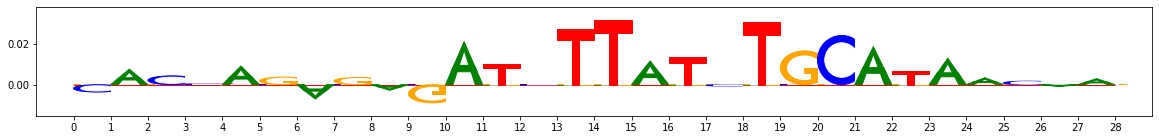

-6


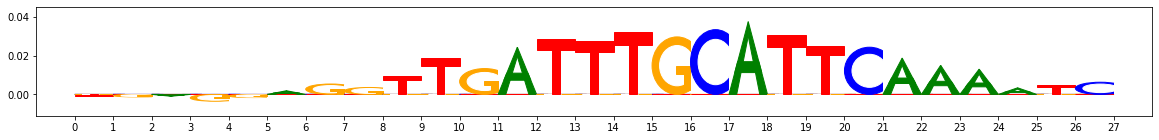

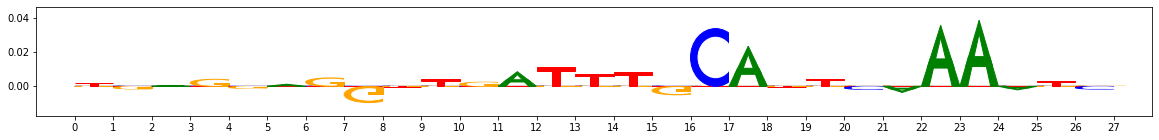

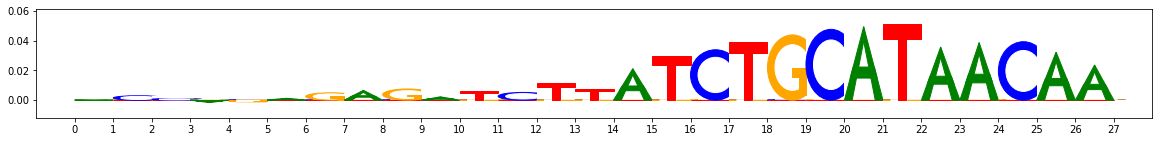

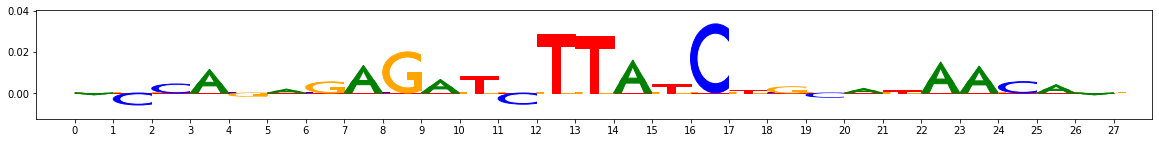

-5


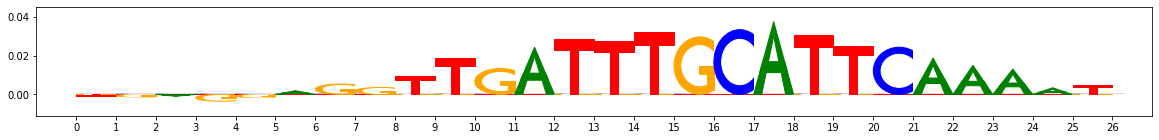

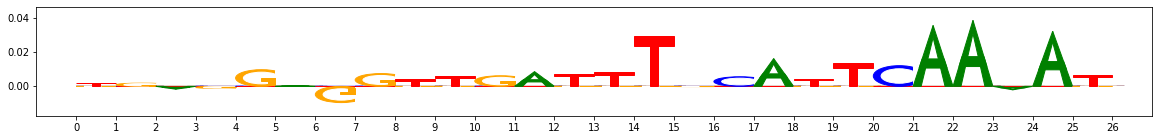

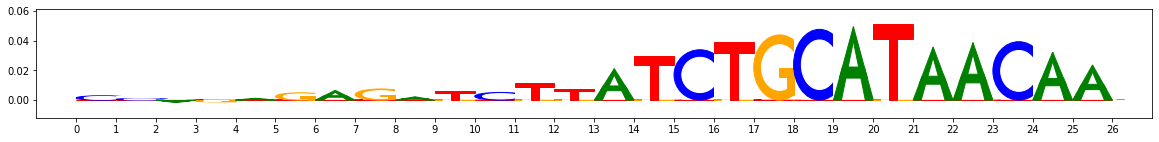

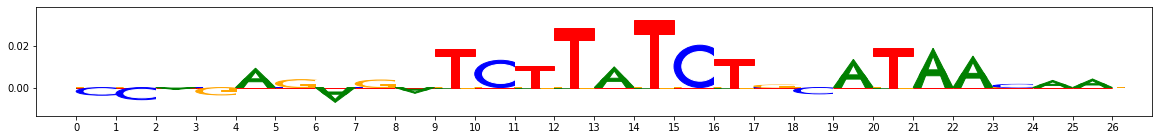

-4


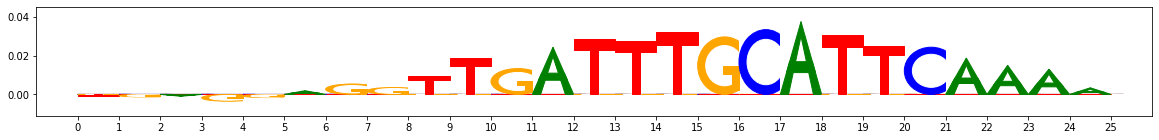

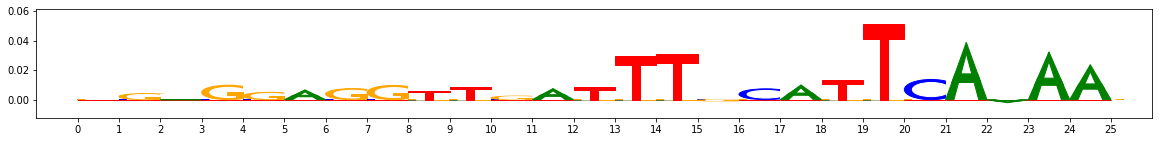

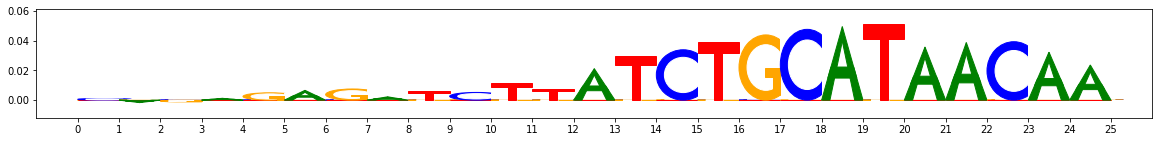

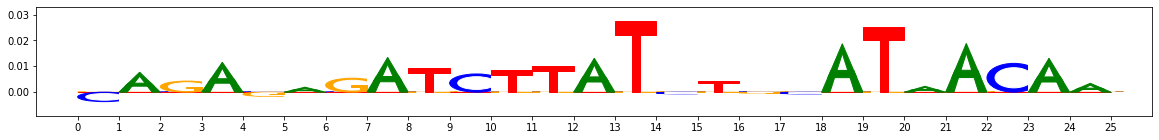

-3


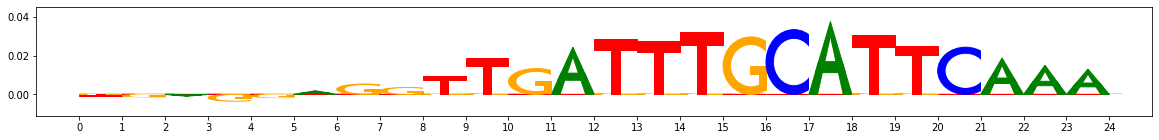

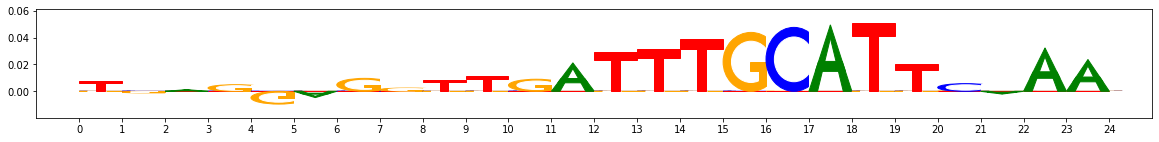

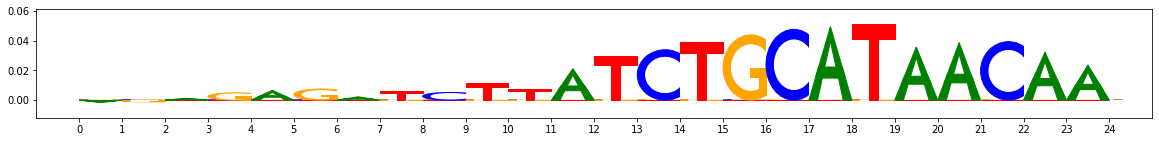

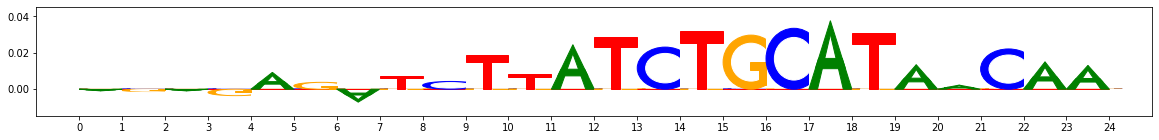

-2


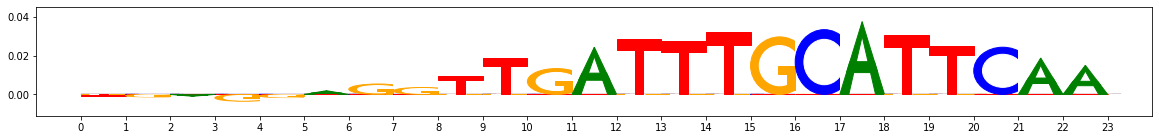

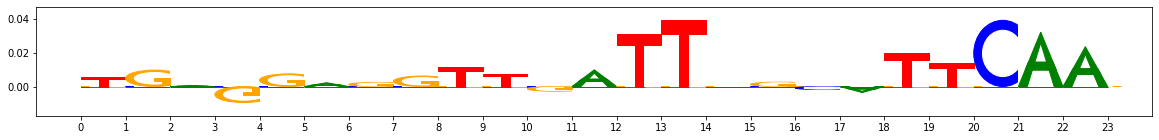

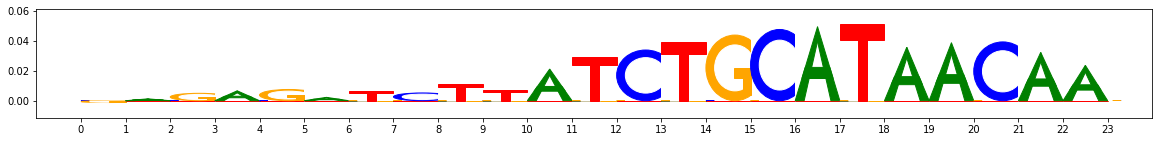

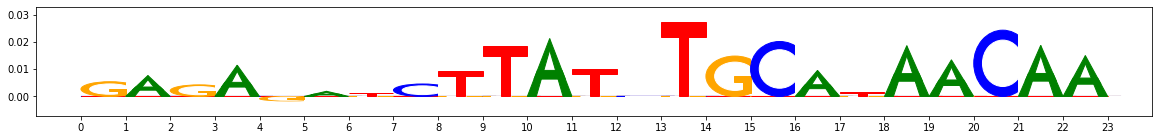

-1


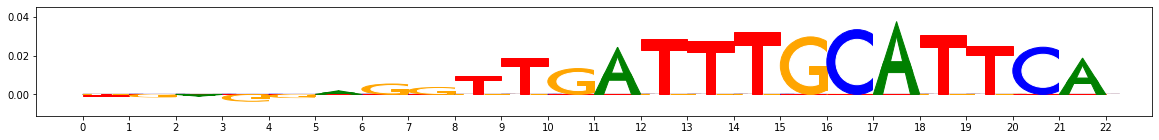

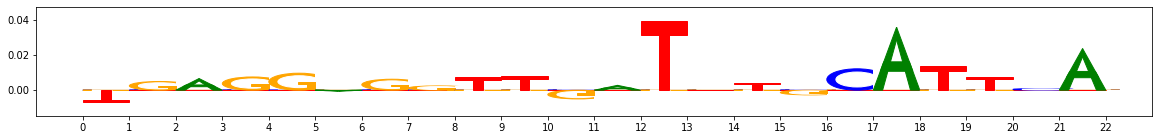

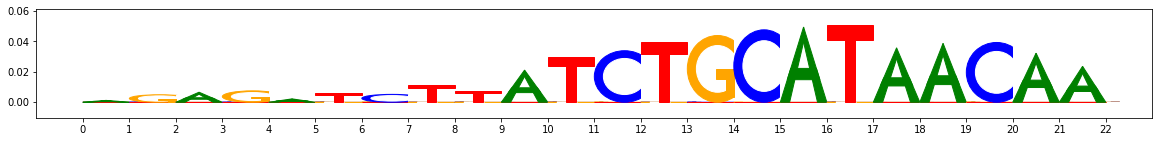

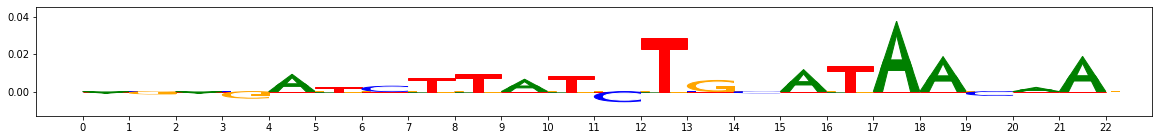

0


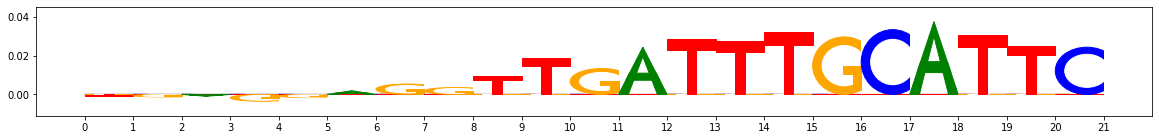

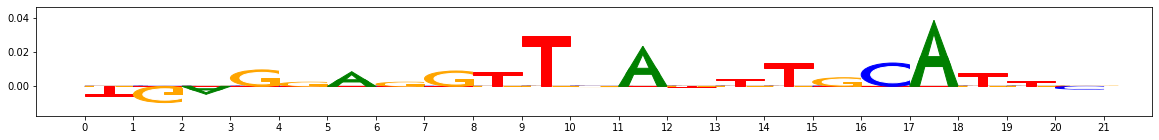

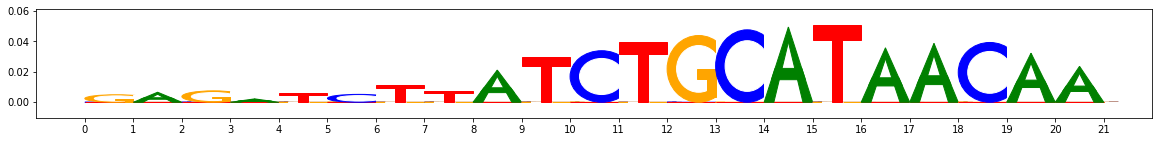

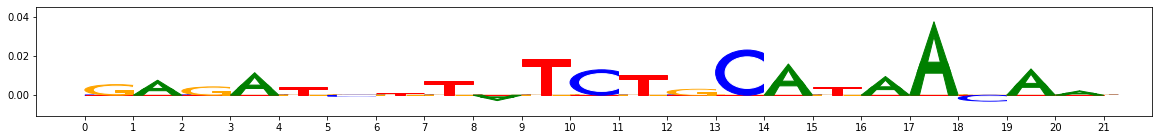

1


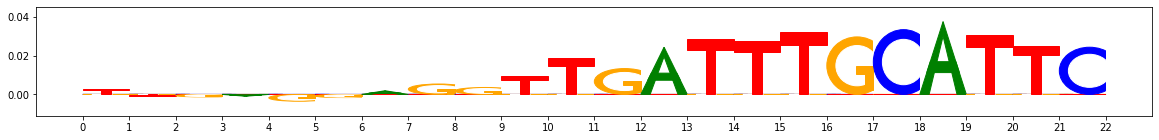

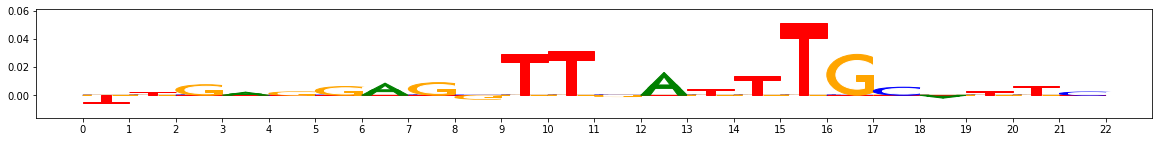

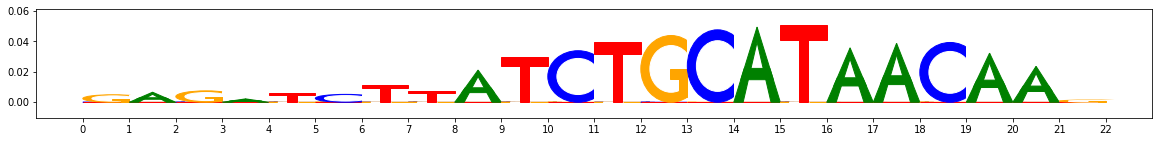

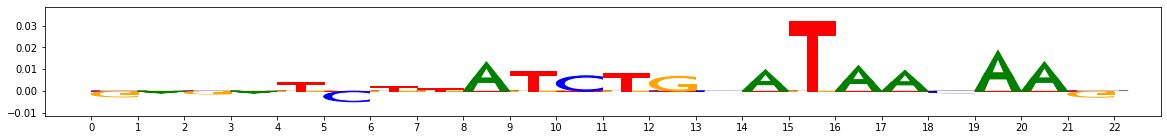

2


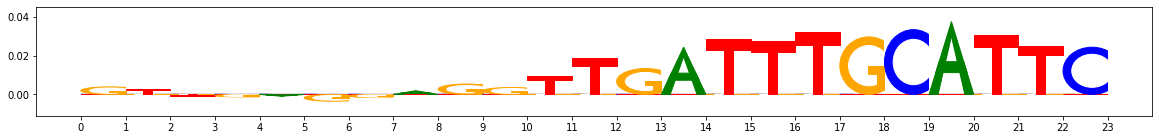

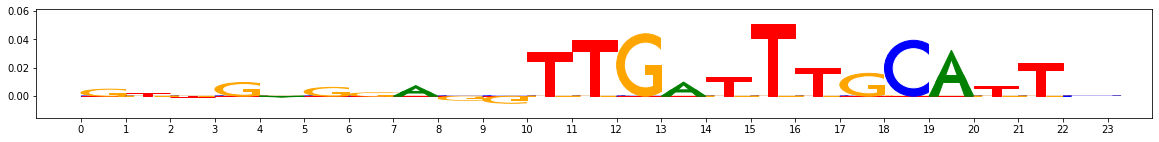

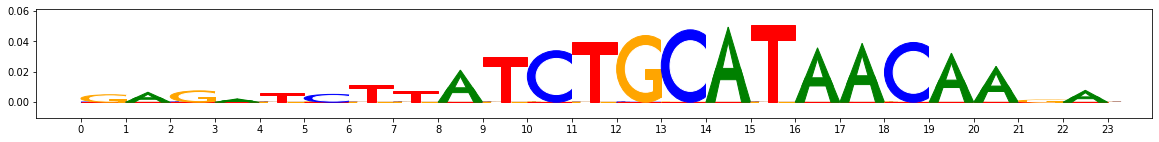

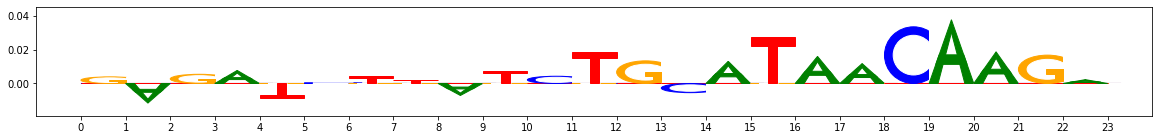

3


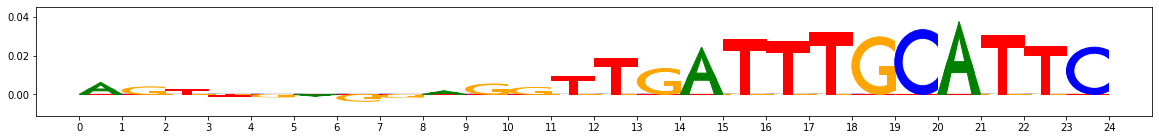

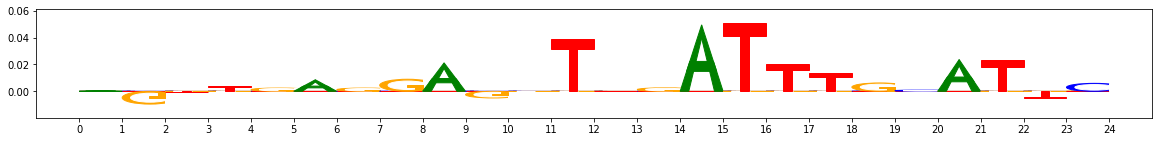

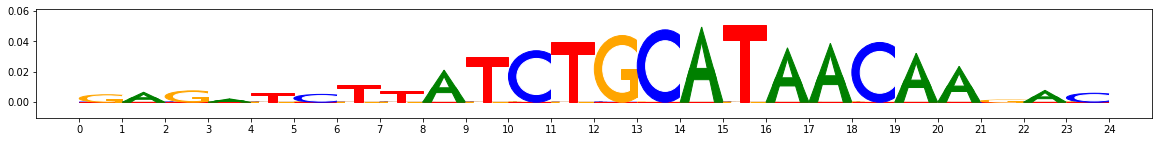

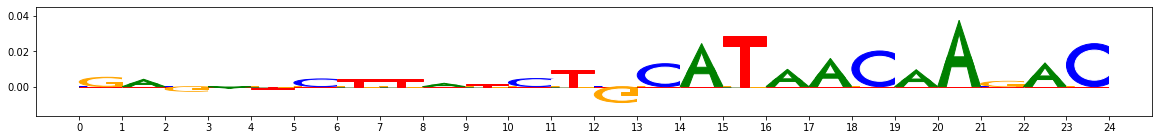

4


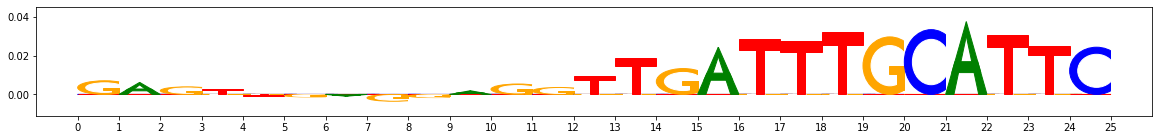

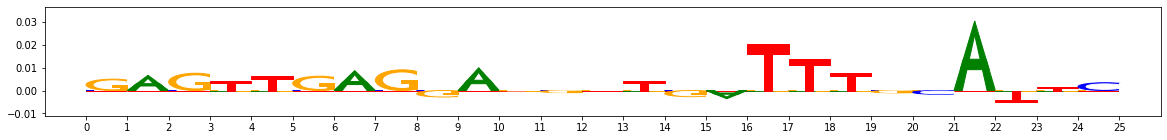

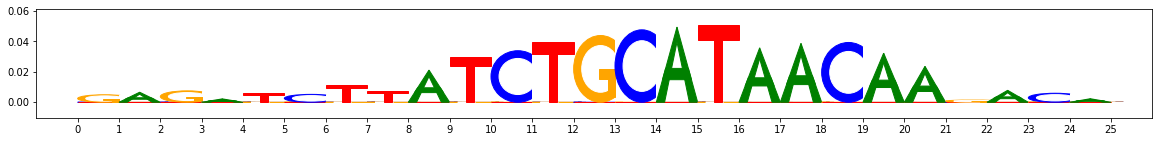

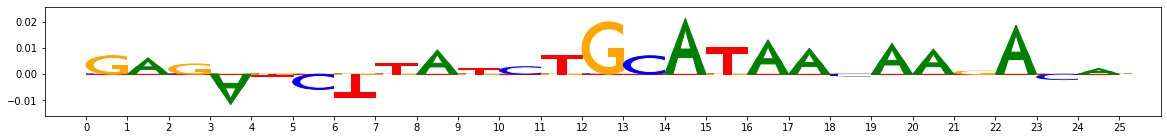

5


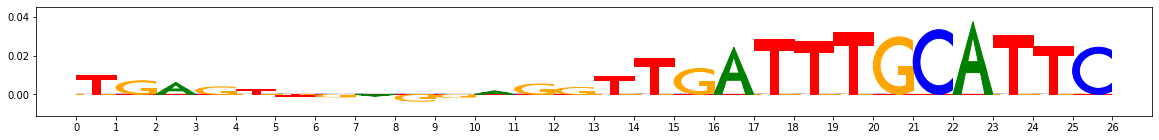

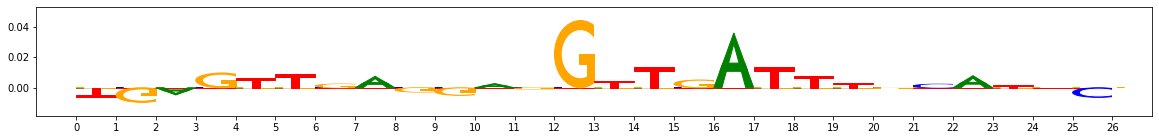

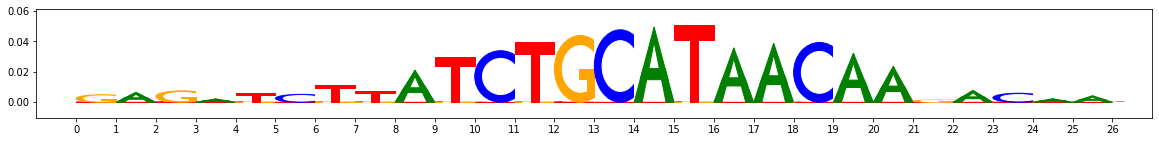

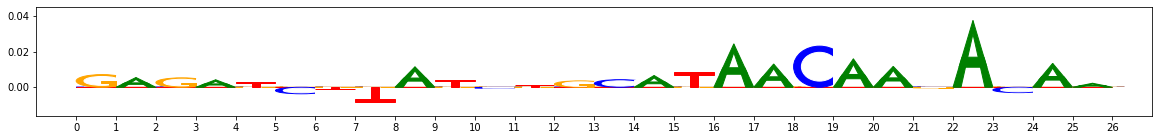

6


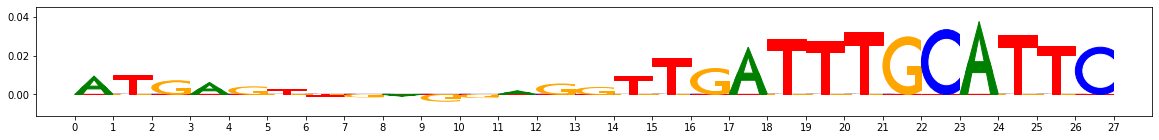

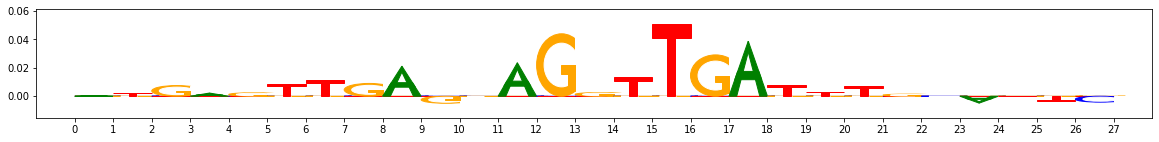

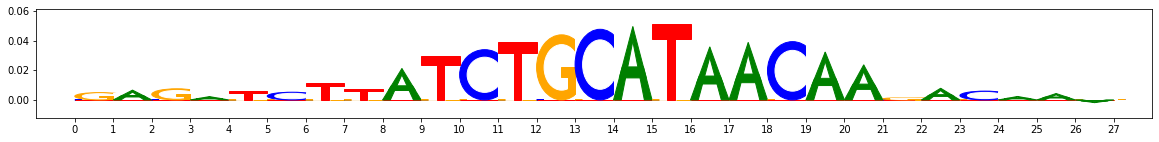

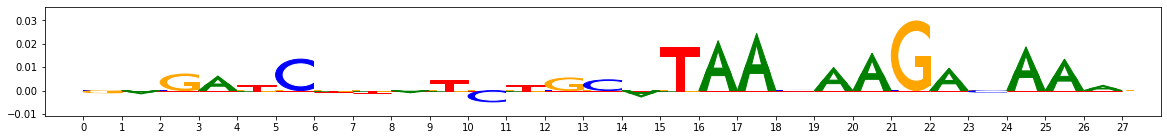

7


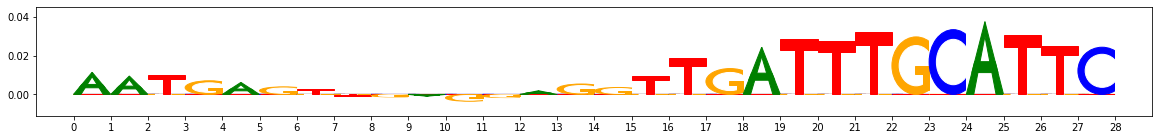

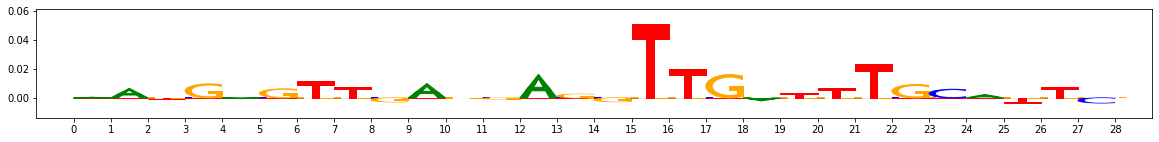

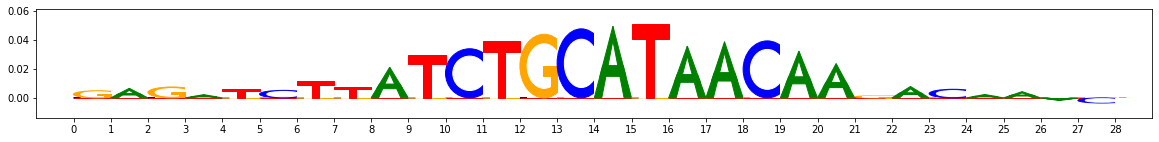

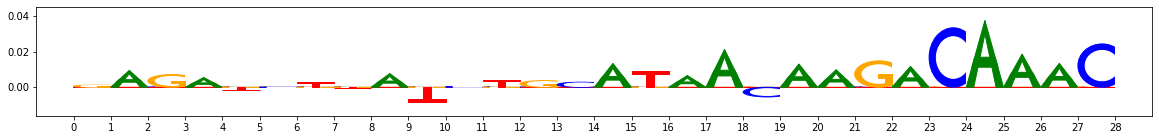

0.6816417444492913

In [108]:
compute_sim_on_pair(seqldat1, seqldat2, min_overlap_frac, modisco.util.l1norm_contin_jaccard_sim)

In [23]:
%lprun?

In [24]:
%lprun -f modisco.affinitymat.compute_sim_on_pair affmat_computer(seqlets[:100], onehot_trackname="onehot", hyp_trackname="hypcontrib_scores")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 10000 out of 10000 | elapsed:   20.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 10000 out of 10000 | elapsed:   19.9s finished


In [54]:
from numba import njit

def l1norm_contin_jaccard_sim(arr1, arr2):                                      
    signarr1 = np.sign(arr1)                                                    
    signarr2 = np.sign(arr2)                                                    
    absarr1 = np.abs(arr1)                                                      
    absarr1 = absarr1/np.sum(absarr1) #l1 norm                                  
    absarr2 = np.abs(arr2)                                                      
    absarr2 = absarr2/np.sum(absarr2) #l1 norm                                  
    return (np.sum(np.minimum(absarr1,absarr2)*signarr1*signarr2)/              
            np.sum(np.maximum(absarr1, absarr2)))

@njit(parallel=True)
def numba_l1norm_contin_jaccard_sim(arr1, arr2):                                      
    signarr1 = np.sign(arr1)                                                    
    signarr2 = np.sign(arr2)                                                    
    absarr1 = np.abs(arr1)                                                      
    absarr1 = absarr1/np.sum(absarr1) #l1 norm                                  
    absarr2 = np.abs(arr2)                                                      
    absarr2 = absarr2/np.sum(absarr2) #l1 norm                                  
    return (np.sum(np.minimum(absarr1,absarr2)*signarr1*signarr2)/              
            np.sum(np.maximum(absarr1, absarr2)))

In [17]:
%lprun -f compute_sim_on_pair compute_sim_on_pair(seqldat1, seqldat2, min_overlap_frac, modisco.util.l1norm_contin_jaccard_sim)

In [6]:
%load_ext line_profiler

In [7]:
def rn():
    for ix in range(0,10): print(ix)

In [9]:
%lprun -f rn rn()

0
1
2
3
4
5
6
7
8
9


In [101]:
%timeit modisco.affinitymat.compute_sim_on_pair(seqldat1, seqldat2, min_overlap_frac, modisco.util.l1norm_contin_jaccard_sim)

1.02 ms ± 7.66 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [60]:
%timeit l1norm_contin_jaccard_sim(arr1, arr2)

28.9 µs ± 480 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [61]:
%timeit numba_l1norm_contin_jaccard_sim(arr1, arr2)

69.7 µs ± 11.3 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [62]:
%timeit numba_l1norm_contin_jaccard_sim(arr1, arr2)

65.9 µs ± 1.84 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
